# Create a shape vs area plot

Plot showing the conceptual backbone of the method with polygons identified as artifacts highlighted.

In [116]:
import os
import json

os.environ["USE_PYGEOS"] = "0"

import geopandas
import geodatasets
import pandas
import numpy
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
from palettable.cartocolors.qualitative import Bold_6
from matplotlib.lines import Line2D
from shapely.affinity import translate

Set default plotting theme.

In [2]:
sns.set_theme(
    context="paper",
    style="ticks",
    rc={
        "patch.force_edgecolor": False,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
    },
    palette=Bold_6.hex_colors,
)

coldict = {
    "Africa": 0,
    "Asia": 1,
    "Europe": 2,
    "North America": 3,
    "Oceania": 4,
    "South America": 5,
}

Read sample.

In [3]:
sample = geopandas.read_parquet("../data/sample.parquet")

Read peak data.

In [4]:
with open("../results/04_peaks_results.json", "r") as fp:
    peaks = json.load(fp)

Specify available FUAs (with validation data).

In [5]:
cities_for_validation = [
    "Abidjan",
    "Conakry",
    "Douala",
    "Mogadishu",  # Africa
    "Aleppo",
    "Kabul",
    "Semarang",
    "Seoul",  # Asia
    "Bucaramanga",
    "Porto Alegre",  # South America
    "Cincinnati",
    "Dallas",
    "Ottawa",
    "Raleigh",
    "Richmond",
    "Río Piedras [San Juan]",
    "Salt Lake City",
    "San Jose",
    "Washington D.C.",  # North America
    "Auckland",  # Oceania
    "Amsterdam",
    "Belgrade",
    "Chelyabinsk",
    "Helsinki",
    "Katowice",
    "Krakow",
    "Liège",
    "Nuremberg",
    "Saratov",
    "Vienna",
    "Warsaw",  # Europe
]

Specify the FUA.

In [6]:
city = "Raleigh"
city_id = int(sample.query(f"eFUA_name == '{city}'").iloc[0].eFUA_ID)

Read FUA data.

In [7]:
fua = geopandas.read_parquet(f"../data/{city_id}/polygons/")

In [8]:
fua

,geometry,circular_compactness,circular_compactness_index,isoperimetric_quotient,isoperimetric_quotient_index,isoareal_quotient,isoareal_quotient_index,radii_ratio,radii_ratio_index,diameter_ratio,diameter_ratio_index,is_artifact,intersection_area
__null_dask_index__,,,,,,,,,,,,,
0,"POLYGON ((710024.592 3933178.872, 710002.805 3...",0.534450,4.834505e+06,0.662749,5.995070e+06,0.814094,7.364098e+06,0.728713,6.591760e+06,0.723315,6.542933e+06,False,26425.826273
1,"POLYGON ((711688.953 3932978.371, 711656.151 3...",0.524388,2.510198e+06,0.679629,3.253321e+06,0.824396,3.946310e+06,0.721821,3.455291e+06,0.621691,2.975981e+06,False,14632.493666
2,"POLYGON ((710916.120 3933252.691, 710888.543 3...",0.478369,2.162271e+05,0.693484,3.134607e+05,0.832757,3.764134e+05,0.689421,3.116244e+05,0.819717,3.705195e+05,False,0.000000
3,"POLYGON ((708507.703 3933161.715, 708641.319 3...",0.511641,5.155510e+05,0.698226,7.035616e+05,0.835599,8.419845e+05,0.712994,7.184421e+05,0.644316,6.492393e+05,False,14486.907718
4,"POLYGON ((708641.319 3933107.082, 708507.703 3...",0.328731,1.044745e+06,0.310024,9.852945e+05,0.556798,1.769572e+06,0.571509,1.816324e+06,0.653367,2.076480e+06,False,36972.522440
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22566,"POLYGON ((718607.693 3949363.386, 718651.330 3...",0.609844,7.793971e+03,0.795076,1.016129e+04,0.891670,1.139579e+04,0.778417,9.948381e+03,0.754242,9.639424e+03,False,202.253586
22567,"POLYGON ((718651.330 3949507.736, 718607.693 3...",0.636218,1.908494e+04,0.858143,2.574214e+04,0.926360,2.778847e+04,0.795071,2.385012e+04,0.882423,2.647047e+04,False,209.092075
22568,"POLYGON ((718192.433 3961585.197, 718190.567 3...",0.557640,5.229887e+03,0.732501,6.869838e+03,0.855863,8.026800e+03,0.744355,6.981009e+03,0.586715,5.502571e+03,False,0.000000


Move geometries to locations of the scatter plot.

In [9]:
centroid = fua.centroid
fua["x"] = centroid.x
fua["y"] = centroid.y
fua["area"] = fua.area

translated = []
for i, row in fua.iterrows():
    y = row.circular_compactness * 10000
    x = row.area / 2
    g = translate(row.geometry, xoff=-(row.x - x), yoff=-(row.y - y))

    translated.append(g)
fua["translated"] = geopandas.GeoSeries(translated)

Retrieve the threshold.

In [58]:
threshold = peaks[city]["circular_compactness_index"]["threshold"]

Filter out extra large polygons.

In [84]:
fua_plot = fua.query("area < 140000").set_geometry("translated")

Create the plot.

/tmp/ipykernel_3444014/4252898903.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
/tmp/ipykernel_3444014/4252898903.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([float(item.get_text().replace(u"\u2212", "-")) * 2 for item in ax.get_xticklabels()])


[Text(-10000.0, 0, '-20000.0'),
 Text(0.0, 0, '0.0'),
 Text(10000.0, 0, '20000.0'),
 Text(20000.0, 0, '40000.0'),
 Text(30000.0, 0, '60000.0'),
 Text(40000.0, 0, '80000.0'),
 Text(50000.0, 0, '100000.0'),
 Text(60000.0, 0, '120000.0'),
 Text(70000.0, 0, '140000.0'),
 Text(80000.0, 0, '160000.0')]

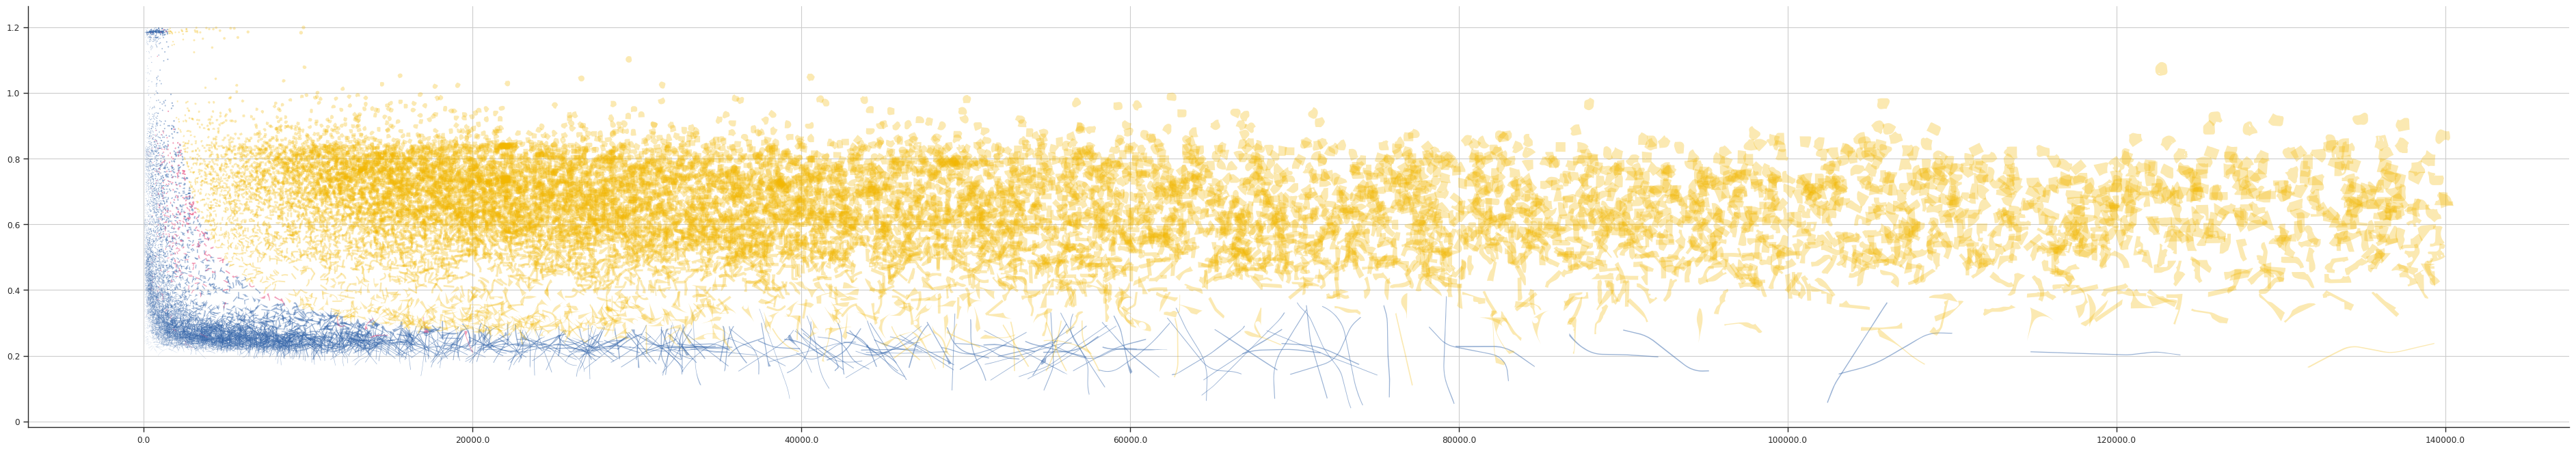

In [85]:
# true positive
ax = fua_plot.query(f"(is_artifact == True) & (intersection_area < 10)").plot(
    aspect=1, figsize=(56, 8), alpha=0.5, color=Bold_6.hex_colors[2]
)
# false positive
fua_plot.query(f"(is_artifact == True) & (intersection_area > 10)").plot(
    aspect=1, alpha=0.5, color=Bold_6.hex_colors[4], ax=ax
)
# negative
fua_plot.query(f"is_artifact == False").plot(
    aspect=1,
    alpha=0.3,
    color=Bold_6.hex_colors[3],
    ax=ax,
)

ax.set_yticklabels([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
ax.set_xticklabels([float(item.get_text().replace(u"\u2212", "-")) * 2 for item in ax.get_xticklabels()])

Filter out extra large polygons.

In [60]:
fua_plot = fua.query("area < 20000").set_geometry("translated")

Create the plot.

/tmp/ipykernel_3444014/3116017415.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
/tmp/ipykernel_3444014/3116017415.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(item.get_text().replace(u"\u2212", "-")) * 2 for item in ax.get_xticklabels()])


[Text(-2000.0, 0, '-4000'),
 Text(0.0, 0, '0'),
 Text(2000.0, 0, '4000'),
 Text(4000.0, 0, '8000'),
 Text(6000.0, 0, '12000'),
 Text(8000.0, 0, '16000'),
 Text(10000.0, 0, '20000'),
 Text(12000.0, 0, '24000')]

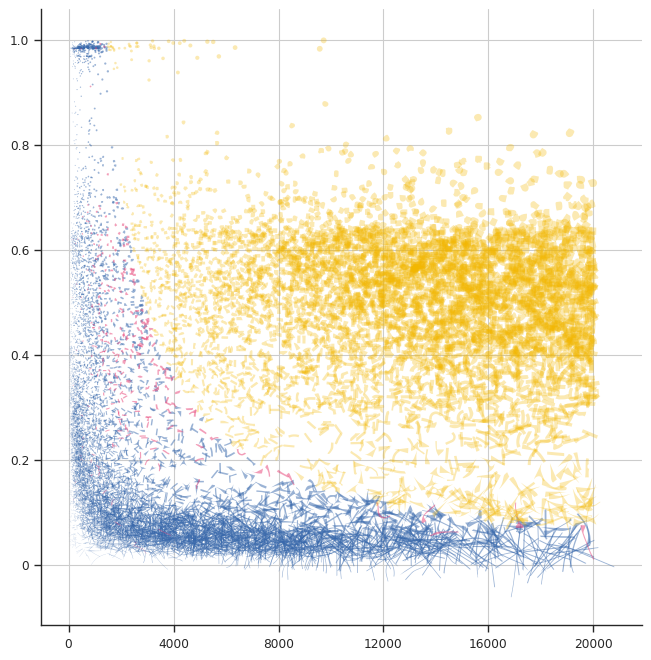

In [61]:
# true positive
ax = fua_plot.query(f"(is_artifact == True) & (intersection_area < 10)").plot(
    aspect=1, figsize=(8, 8), alpha=0.5, color=Bold_6.hex_colors[2]
)
# false positive
fua_plot.query(f"(is_artifact == True) & (intersection_area > 10)").plot(
    aspect=1, alpha=0.5, color=Bold_6.hex_colors[4], ax=ax
)
# negative
fua_plot.query(f"is_artifact == False").plot(
    aspect=1,
    alpha=0.3,
    color=Bold_6.hex_colors[3],
    ax=ax,
)

ax.set_yticklabels([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
ax.set_xticklabels([int(item.get_text().replace(u"\u2212", "-")) * 2 for item in ax.get_xticklabels()])

/tmp/ipykernel_3444014/1026813279.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([float(item.get_text().replace(u"\u2212", "-")) / 10000 for item in ax.get_yticklabels()])
/tmp/ipykernel_3444014/1026813279.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(item.get_text().replace(u"\u2212", "-")) * 2 for item in ax.get_xticklabels()])
/tmp/ipykernel_3444014/1026813279.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([float(item.get_text().replace(u"\u2212", "-")) / 10000 for item in ax.get_yticklabels()])
/tmp/ipykernel_3444014/1026813279.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(item.get_text().replace(u"\u2212", "-")) * 2 for item in ax.get_xticklabels()])


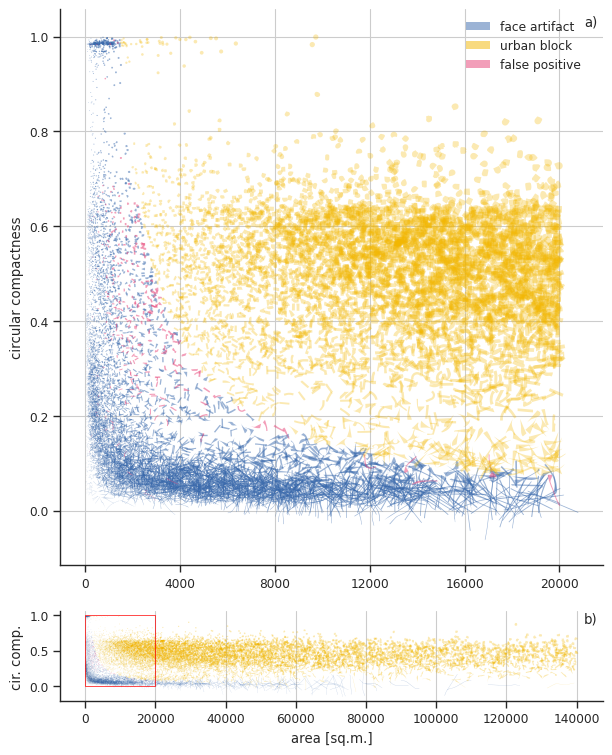

In [127]:
grid = [
        ["zoom"] * 7
    ] * 7
grid.append(["whole"] * 7)
grid.append(["whole"] * 7)

fig, axs = plt.subplot_mosaic(
    grid,
    figsize=(7, 9.4),
)

plot_data = {
    "zoom": fua.query("area < 20000").set_geometry("translated"),
    "whole": fua.query("area < 140000").set_geometry("translated"),
}

for sp in plot_data:
    
    ax = axs[sp]
    fua_plot = plot_data[sp]

    fua_plot.query(f"(is_artifact == True) & (intersection_area < 10)").plot(
        aspect=1, ax=ax, alpha=0.5, color=Bold_6.hex_colors[2]
    )
    # false positive
    fua_plot.query(f"(is_artifact == True) & (intersection_area > 10)").plot(
        aspect=1, alpha=0.5, color=Bold_6.hex_colors[4], ax=ax
    )
    # negative
    fua_plot.query(f"is_artifact == False").plot(
        aspect=1,
        alpha=0.3,
        color=Bold_6.hex_colors[3],
        ax=ax,
    )

    ax.set_yticklabels([float(item.get_text().replace(u"\u2212", "-")) / 10000 for item in ax.get_yticklabels()])
    ax.set_xticklabels([int(item.get_text().replace(u"\u2212", "-")) * 2 for item in ax.get_xticklabels()])
    
axs["whole"].set_xlabel("area [sq.m.]")
axs["zoom"].set_ylabel("circular compactness")
axs["whole"].set_ylabel("cir. comp.")
axs["whole"].yaxis.grid(False)

rect = patches.Rectangle((0, 0), 10000, 10000, linewidth=.5, edgecolor='r', facecolor='none')

axs["whole"].add_patch(rect)

axs["zoom"].text(.99, .99, "a)", horizontalalignment='right',
        verticalalignment='top', transform=axs["zoom"].transAxes)
axs["whole"].text(.99, .99, "b)", horizontalalignment='right',
        verticalalignment='top', transform=axs["whole"].transAxes)



legend_elements = [
    patches.Patch(facecolor=Bold_6.hex_colors[2], alpha=0.5, label='face artifact'),
    patches.Patch(facecolor=Bold_6.hex_colors[3], alpha=0.5, label='urban block'),
    patches.Patch(facecolor=Bold_6.hex_colors[4], alpha=0.5, label='false positive'),
    
]

axs["zoom"].legend(handles=legend_elements, loc='upper right', frameon=False, bbox_to_anchor=(.98, 1.0))
plt.savefig("../plots/shapes/banana.png", dpi=300, bbox_inches="tight")